<a href="https://colab.research.google.com/github/srilamaiti/SM_MIDS_W207_HW/blob/main/w207_cancer_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Importing the libraries***

In [1]:
import pandas as pd
import numpy as np
import os
import random
import joblib
import glob

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import matplotlib.patches as patches

from sklearn.utils import shuffle
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import RandomFlip
from tensorflow.keras.layers import RandomZoom
from tensorflow.keras.layers import RandomRotation
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
import cv2 as cv
import skimage.io as skio

# Required to read the data from Kaggle
from google.colab import drive
drive.mount('/content/gdrive')
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/Kaggle"

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# ***Downloading titanic data set from Kaggle, it will download a zip file from Kaggle platform to Google Colab***

In [3]:
!kaggle competitions download -c histopathologic-cancer-detection

100% 6.30G/6.31G [00:44<00:00, 136MB/s]
100% 6.31G/6.31G [00:44<00:00, 152MB/s]


# ***Unzipping the downaloaded zip files and then remove the actual zip file***

In [ ]:
!unzip \*.zip  && rm *.zip

# ***Train Files Count***

In [2]:
!ls -ltr /content/train/ |wc -l

220026


# ***Validate train_labels.csv file count, it should match with train file count***

In [3]:
!wc -l train_labels.csv

220026 train_labels.csv


# ***Test Files Count***

In [4]:
!ls -ltr /content/test/ |wc -l

57459


# ***Validate submission file count, it should match with test file count***

In [5]:
!wc -l sample_submission.csv

57459 sample_submission.csv


In [6]:
tf.__version__

'2.8.2'

In [7]:
# declare constants for reproduciblity
RANDOM_STATE = 20220922

# ***Explore file structure of train_labels.csv***

In [8]:
!head train_labels.csv

id,label
f38a6374c348f90b587e046aac6079959adf3835,0
c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
755db6279dae599ebb4d39a9123cce439965282d,0
bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
068aba587a4950175d04c680d38943fd488d6a9d,0
acfe80838488fae3c89bd21ade75be5c34e66be7,0
a24ce148f6ffa7ef8eefb4efb12ebffe8dd700da,1
7f6ccae485af121e0b6ee733022e226ee6b0c65f,1
559e55a64c9ba828f700e948f6886f4cea919261,0


# ***Explore file structure of sample_submission.csv***

In [9]:
!head sample_submission.csv

id,label
0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
95596b92e5066c5c52466c90b69ff089b39f2737,0
248e6738860e2ebcf6258cdc1f32f299e0c76914,0
2c35657e312966e9294eac6841726ff3a748febf,0
145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0
725dabe6ecccc68b958a2c7dd75bcbf362c7cb03,0
aa0307865281d4484ddf8c637c348292968b93a7,0
f4e5dc9c949920f1b3362982e15e99bf6f3ef83b,0
95e08c9cedc28a9b4a86f4fc1e06c1972134be08,0


# ***Read files***

In [11]:
#get files
current_working_dir = os.getcwd()
train_path = 'train/'
test_path = 'test/'

train_file_list = []
for train_file_name in glob.glob(os.path.join(current_working_dir, train_path)+'*.tif'):
    train_file_list.append(train_file_name)

test_file_list = []
for test_file_name in glob.glob(os.path.join(current_working_dir, test_path)+'*.tif'):
    test_file_list.append(test_file_name)

test_label = pd.read_csv('sample_submission.csv')
train_label = pd.read_csv('train_labels.csv')

In [12]:
print(f"Number of train files : {len(train_file_list)}")
print(f"Number of train files : {len(test_file_list)}")

Number of train files : 220025
Number of train files : 57458


Text(0.5, 1.0, 'Train Data label Count')

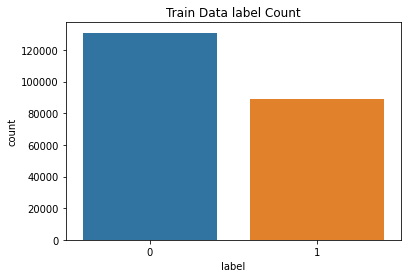

In [22]:
sns.countplot(data = train_label, x = 'label')
plt.title("Train Data label Count")

In [27]:
fig = px.pie(train_label, 
             values = train_label['label'].value_counts().values, 
             names = train_label['label'].unique())
fig.update_layout(
    title={
        'text': "Train Label Percentage Pie Chart",
        'y':.99,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

Text(0.5, 1.0, 'Test Data label Count')

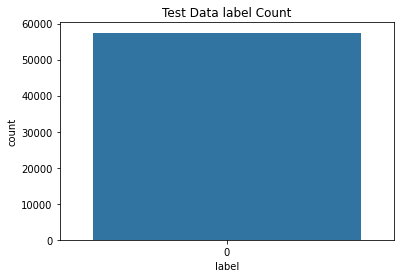

In [23]:
sns.countplot(data = test_label, x = 'label')
plt.title("Test Data label Count")

In [26]:
fig = px.pie(test_label, 
             values = test_label['label'].value_counts().values, 
             names = test_label['label'].unique())
fig.update_layout(
    title={
        'text': "Test Label Percentage Pie Chart",
        'y':.99,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

# This data contains 220,025 train images and 57,458 test images (Tiff Files). All the images are 96 X 96 color images (with 3 channels). We are also given train_labels.csv and sample_submission.csv which contain label information for train and test images respectively.

213.49490017361111


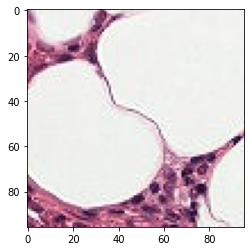

130.34505208333334


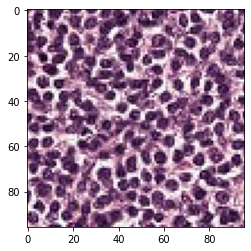

139.83467158564815


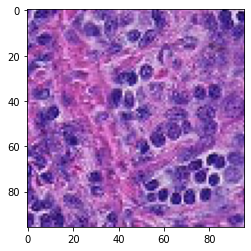

188.07588252314815


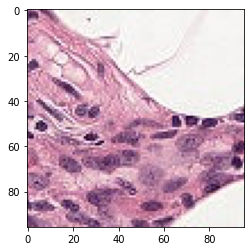

100.44364872685185


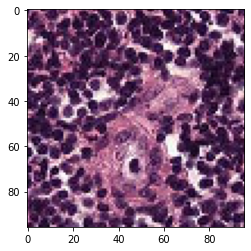

153.84226707175927


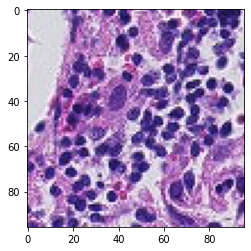

158.45146122685185


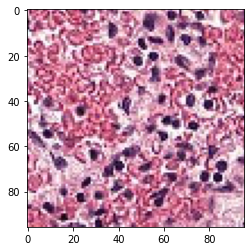

154.64228877314815


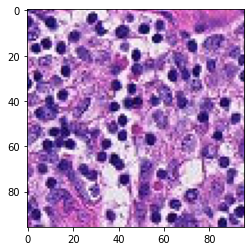

212.68645109953704


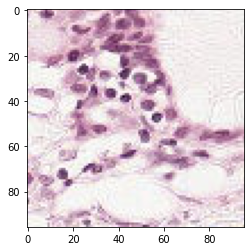

131.44560185185185


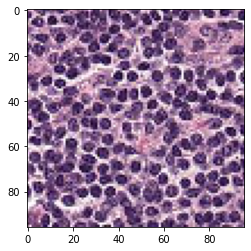

In [28]:
for train_file in train_file_list[:10]:
    train_image = skio.imread(train_file, plugin = "tifffile")
    print(train_image.mean())
    plt.imshow(train_image)
    plt.show()